In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

import numpy as np
import io
import json

import matplotlib.pyplot as plt

In [9]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json -O /tmp/sarcasm.json

with open("/tmp/sarcasm.json","r") as f:
  datastore = json.load(f)

sentences = []
labels = []
for eachItem in datastore:
  sentences.append(eachItem['headline'])
  labels.append(eachItem['is_sarcastic'])

--2020-06-19 08:23:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2020-06-19 08:23:12 (207 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [14]:
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_token = "<OOV>"
training_size = 20000

num_epochs = 10

In [15]:
training_sentences = sentences[:training_size]
training_labels = labels[:training_size]

testing_sentences = sentences[training_size:]
testing_labels = labels[training_size:]

In [12]:
tokenizer = Tokenizer(vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

In [16]:
training_padded = np.array(training_padded)
testing_padded = np.array(testing_padded)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [13]:
## model with flatten
model_conv = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
                                  tf.keras.layers.Conv1D(128,5,activation='relu'),
                                  tf.keras.layers.GlobalAveragePooling1D(),
                                  tf.keras.layers.Dense(24,activation='relu'),
                                  tf.keras.layers.Dense(1,activation='sigmoid')

])

model_conv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 16)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 128)           10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 173,489
Trainable params: 173,489
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history_conv = model_conv.fit(training_padded,training_labels,epochs=num_epochs,validation_data=(testing_padded,testing_labels))

Epoch 1/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4716 - accuracy: 0.7584 - val_loss: 0.3637 - val_accuracy: 0.8393
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2498 - accuracy: 0.8982 - val_loss: 0.3605 - val_accuracy: 0.8453
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1729 - accuracy: 0.9330 - val_loss: 0.4027 - val_accuracy: 0.8420
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1219 - accuracy: 0.9559 - val_loss: 0.4696 - val_accuracy: 0.8381
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.0804 - accuracy: 0.9737 - val_loss: 0.6221 - val_accuracy: 0.8317
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.0499 - accuracy: 0.9844 - val_loss: 0.7104 - val_accuracy: 0.8310
Epoch 7/10
625/625 [==============================] - 5s 7ms/step - loss: 0.0282 - accuracy: 0.9923 - val_loss: 0.8613 - val_accuracy: 0.8277
Epoch 

In [19]:
import matplotlib.pyplot as plt

def plot_graphs(history,string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string,'val_'+string])
  plt.show()

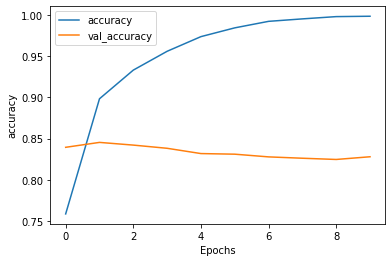

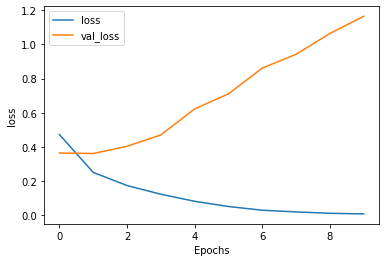

In [20]:
plot_graphs(history_conv,'accuracy')
plot_graphs(history_conv,'loss')

In [21]:
## model with lstm
model_lstm = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
                                  tf.keras.layers.Dense(24,activation='relu'),
                                  tf.keras.layers.Dense(1,activation='sigmoid')

])

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 165,041
Trainable params: 165,041
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history_lstm = model_lstm.fit(training_padded,training_labels,epochs=num_epochs,validation_data=(testing_padded,testing_labels))

Epoch 1/10
625/625 [==============================] - 11s 18ms/step - loss: 0.4153 - accuracy: 0.7965 - val_loss: 0.3357 - val_accuracy: 0.8521
Epoch 2/10
625/625 [==============================] - 11s 17ms/step - loss: 0.2263 - accuracy: 0.9069 - val_loss: 0.3537 - val_accuracy: 0.8526
Epoch 3/10
625/625 [==============================] - 11s 17ms/step - loss: 0.1587 - accuracy: 0.9384 - val_loss: 0.3953 - val_accuracy: 0.8495
Epoch 4/10
625/625 [==============================] - 11s 17ms/step - loss: 0.1158 - accuracy: 0.9576 - val_loss: 0.4626 - val_accuracy: 0.8425
Epoch 5/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0814 - accuracy: 0.9719 - val_loss: 0.5380 - val_accuracy: 0.8392
Epoch 6/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0582 - accuracy: 0.9801 - val_loss: 0.5964 - val_accuracy: 0.8411
Epoch 7/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0353 - accuracy: 0.9890 - val_loss: 0.7461 - val_accuracy:

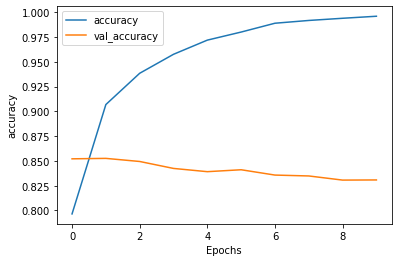

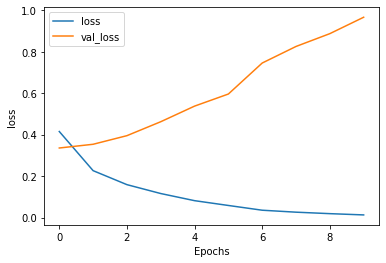

In [23]:
plot_graphs(history_lstm,'accuracy')
plot_graphs(history_lstm,'loss')

In [24]:
## model with gru
model_gru = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(embedding_dim)),
                                  tf.keras.layers.Dense(24,activation='relu'),
                                  tf.keras.layers.Dense(1,activation='sigmoid')

])

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                3264      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 164,081
Trainable params: 164,081
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history_gru = model_gru.fit(training_padded,training_labels,epochs=num_epochs,validation_data=(testing_padded,testing_labels))

Epoch 1/10
625/625 [==============================] - 11s 18ms/step - loss: 0.4080 - accuracy: 0.8009 - val_loss: 0.3581 - val_accuracy: 0.8442
Epoch 2/10
625/625 [==============================] - 11s 17ms/step - loss: 0.2292 - accuracy: 0.9066 - val_loss: 0.3489 - val_accuracy: 0.8530
Epoch 3/10
625/625 [==============================] - 11s 17ms/step - loss: 0.1642 - accuracy: 0.9370 - val_loss: 0.4180 - val_accuracy: 0.8426
Epoch 4/10
625/625 [==============================] - 11s 17ms/step - loss: 0.1226 - accuracy: 0.9538 - val_loss: 0.4819 - val_accuracy: 0.8386
Epoch 5/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0918 - accuracy: 0.9678 - val_loss: 0.4963 - val_accuracy: 0.8350
Epoch 6/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0666 - accuracy: 0.9772 - val_loss: 0.6077 - val_accuracy: 0.8348
Epoch 7/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0443 - accuracy: 0.9862 - val_loss: 0.7121 - val_accuracy:

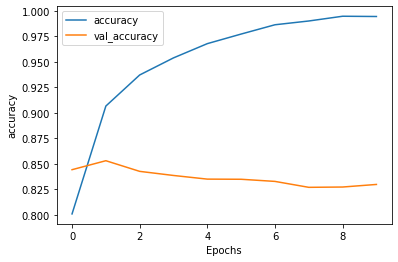

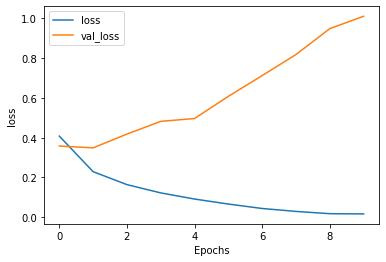

In [26]:
plot_graphs(history_gru,'accuracy')
plot_graphs(history_gru,'loss')